### Check time evolution of terms in the vorticity formulation
This notebook finds the terms in the vorticity formulation and makes of a video of their time-evolution.

In [1]:
import os
import sys
sys.path.append("../") # go to parent dir
import glob
import time
import pathlib
import logging
import numpy as np
from dedalus.tools.config import config
from simple_sphere import SimpleSphere, TensorField, TensorSystem
import equations
import matplotlib.pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs
import logging
from mpl_toolkits import mplot3d
logger = logging.getLogger(__name__)
from matplotlib.animation import FFMpegWriter
from dedalus.extras import plot_tools
import copy as cp

#add path to data folder
input_folder = "/Users/Rohit/Documents/research/active_matter_spheres/scripts/data/sphere66"
output_folder = "/Users/Rohit/Documents/research/active_matter_spheres/scripts/videos"

#define the simulation parameters
Omega, Lmid, kappa = 250, 4, 1 

first_frame = 1
last_frame = len(glob.glob1("".join([input_folder,'/']),"*.npz"))
last_frame = 300
dpi = 256
fields = ['om','v_ph']

t_arr = np.zeros(last_frame - first_frame + 1)

### Define the active dispersion relation

In [2]:
#get gammas from Lmid and kappa setting R=1 and tau=1
def get_gammas(Lmid, kappa):
    a = 0.25*(Lmid**2*kappa**2 - 0.5*(2*np.pi*Lmid+1)**2)**2 + 17*17/16 - (34/16)*(2*np.pi*Lmid+1)**2
    b = (17/4 - 0.25*(2*np.pi*Lmid+1)**2)**2
    c = 1/(17/4 - 0.25*(2*np.pi*Lmid + 1)**2 - 2)
    gamma0 = a*c/(a-b)
    gamma2 = -2*np.sqrt(b)*c/(a-b)
    gamma4 = c/(a-b)
    
    return gamma0, gamma2, gamma4

#get the value of the dispersion polynomial
def get_f(Lmid, kappa, x):
    gamma0, gamma2, gamma4 = get_gammas(Lmid, kappa)
    f = gamma0 - gamma2*x + gamma4*x**2
    return f

F = lambda x: get_f(Lmid, kappa, x)


In [3]:
## find psi and activity term in real space 

for ind in range(first_frame, last_frame + 1, 1):
    #if np.mod(ind,100)==0: 
    logger.info('Frame:%i'%(ind))
    
    with np.load(os.path.join(input_folder, 'output_%i.npz' %(ind))) as file:
        if ind == first_frame:
            phi = file['phi']
            theta = file['theta']
            L_max = len(theta)-1
            S_max = 4
            simplesphere = SimpleSphere(L_max, S_max)
            omega = TensorField(simplesphere, rank=0)
            
            psi = TensorField(simplesphere, rank=0)
            activity = TensorField(simplesphere, rank=0)
            coeffs_all = np.zeros((last_frame,L_max+1, L_max+1), dtype=complex)
            
            om_arr = np.zeros((t_arr.shape[0], 2*(L_max+1), L_max+1))
            psi_arr = np.zeros_like(om_arr)
            activity_arr = np.zeros_like(om_arr)
            

        om_arr[ind-1, :, :] = file['om']
        time = file['t'][0]
        t_arr[ind-1] = time
        
        # assign loaded data
        omega.component_fields[0]['g'] = file['om']
        # spectral transform
        omega.forward_phi()
        omega.forward_theta()
        coeffs = omega.coeffs
        
        psi_coeffs = cp.deepcopy(coeffs)
        activity_coeffs = cp.deepcopy(coeffs)
        for dm, m in enumerate(simplesphere.local_m):
            for ell in range(m, L_max+1):
                if ell != 0:
                    psi_coeffs[dm][ell-m] = psi_coeffs[dm][ell-m]/(ell*(ell+1))
                activity_coeffs[dm][ell-m] = F(-ell*(ell+1) + 4)*(-ell*(ell+1) + 2)*activity_coeffs[dm][ell-m]
                
        psi.coeffs = cp.deepcopy(psi_coeffs)
        activity.coeffs = cp.deepcopy(activity_coeffs)
        
        # backward transforms 
        psi.backward_theta()
        psi.backward_phi()
        activity.backward_theta()
        activity.backward_phi()
        
        psi_arr[ind-1, :, :] = psi.component_fields[0]['g']
        activity_arr[ind-1, :, :] = activity.component_fields[0]['g']
            
        for m in range(len(coeffs)):
            coeffs_all[ind-1, m, m:] = coeffs[m]
            

2019-07-22 14:48:52,281 __main__ 0/1 INFO :: Frame:1
2019-07-22 14:49:02,638 __main__ 0/1 INFO :: Frame:2
2019-07-22 14:49:03,142 __main__ 0/1 INFO :: Frame:3
2019-07-22 14:49:03,639 __main__ 0/1 INFO :: Frame:4
2019-07-22 14:49:04,116 __main__ 0/1 INFO :: Frame:5
2019-07-22 14:49:04,618 __main__ 0/1 INFO :: Frame:6
2019-07-22 14:49:05,100 __main__ 0/1 INFO :: Frame:7
2019-07-22 14:49:05,570 __main__ 0/1 INFO :: Frame:8
2019-07-22 14:49:06,044 __main__ 0/1 INFO :: Frame:9
2019-07-22 14:49:06,530 __main__ 0/1 INFO :: Frame:10
2019-07-22 14:49:06,998 __main__ 0/1 INFO :: Frame:11
2019-07-22 14:49:07,489 __main__ 0/1 INFO :: Frame:12
2019-07-22 14:49:07,951 __main__ 0/1 INFO :: Frame:13
2019-07-22 14:49:08,420 __main__ 0/1 INFO :: Frame:14
2019-07-22 14:49:08,882 __main__ 0/1 INFO :: Frame:15
2019-07-22 14:49:09,349 __main__ 0/1 INFO :: Frame:16
2019-07-22 14:49:09,812 __main__ 0/1 INFO :: Frame:17
2019-07-22 14:49:10,273 __main__ 0/1 INFO :: Frame:18
2019-07-22 14:49:10,740 __main__ 0/1 

2019-07-22 14:50:16,496 __main__ 0/1 INFO :: Frame:152
2019-07-22 14:50:17,088 __main__ 0/1 INFO :: Frame:153
2019-07-22 14:50:17,616 __main__ 0/1 INFO :: Frame:154
2019-07-22 14:50:18,182 __main__ 0/1 INFO :: Frame:155
2019-07-22 14:50:18,717 __main__ 0/1 INFO :: Frame:156
2019-07-22 14:50:19,185 __main__ 0/1 INFO :: Frame:157
2019-07-22 14:50:19,646 __main__ 0/1 INFO :: Frame:158
2019-07-22 14:50:20,170 __main__ 0/1 INFO :: Frame:159
2019-07-22 14:50:20,636 __main__ 0/1 INFO :: Frame:160
2019-07-22 14:50:21,156 __main__ 0/1 INFO :: Frame:161
2019-07-22 14:50:21,616 __main__ 0/1 INFO :: Frame:162
2019-07-22 14:50:22,084 __main__ 0/1 INFO :: Frame:163
2019-07-22 14:50:22,550 __main__ 0/1 INFO :: Frame:164
2019-07-22 14:50:23,010 __main__ 0/1 INFO :: Frame:165
2019-07-22 14:50:23,473 __main__ 0/1 INFO :: Frame:166
2019-07-22 14:50:23,937 __main__ 0/1 INFO :: Frame:167
2019-07-22 14:50:24,454 __main__ 0/1 INFO :: Frame:168
2019-07-22 14:50:24,910 __main__ 0/1 INFO :: Frame:169
2019-07-22

In [4]:
#Find the max of the fields

data_dict = {'activity': activity_arr, 'psi': psi_arr, 'om': om_arr}

fields = data_dict.keys()
max_vals = {key: 0 for key in fields}
clims = {key: 0 for key in fields}

for field in fields:
    for i in range(first_frame, last_frame + 1, 1):
        fieldval = data_dict[field][i-1, :, :]
        max_vals[field] = max(max_vals[field], np.max(fieldval))

for field in fields:
    clims[field] = 0.75*max_vals[field]

2019-07-22 14:44:50,060 matplotlib.animation 0/1 INFO :: MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '2304x2048', '-pix_fmt', 'rgba', '-r', '15', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-metadata', 'title=Movie', '-metadata', 'artist=Matplotlib', '-metadata', 'comment=Movie support!', '-y', '/Users/Rohit/Documents/research/active_matter_spheres/scripts/videos/time_evolve.mp4']
2019-07-22 14:44:54,294 __main__ 0/1 INFO :: Frame: 10
2019-07-22 14:44:58,271 __main__ 0/1 INFO :: Frame: 20
2019-07-22 14:45:02,357 __main__ 0/1 INFO :: Frame: 30
2019-07-22 14:45:06,210 __main__ 0/1 INFO :: Frame: 40
2019-07-22 14:45:10,234 __main__ 0/1 INFO :: Frame: 50
2019-07-22 14:45:14,242 __main__ 0/1 INFO :: Frame: 60
2019-07-22 14:45:18,283 __main__ 0/1 INFO :: Frame: 70
2019-07-22 14:45:22,152 __main__ 0/1 INFO :: Frame: 80
2019-07-22 14:45:26,013 __main__ 0/1 INFO :: Frame: 90
2019-07-22 14:45:29,870 __main__ 0/1 INFO :: Frame: 100
201

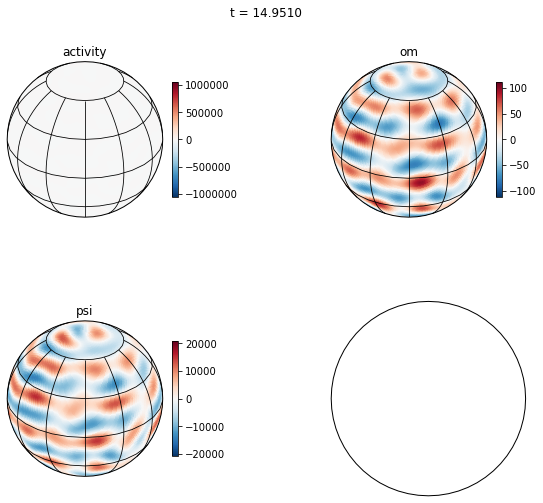

In [5]:
plt.rc('text', usetex=False)

fig = plt.figure(figsize=(9,8))
proj = ccrs.Orthographic(central_longitude=0, central_latitude=30)

FPS = 15
metadata = dict(title='Movie', artist='Matplotlib', comment='Movie support!')
writer = FFMpegWriter(fps=FPS, metadata=metadata)
edgecolor = 'k'
axes1 = plt.axes((0.1, 0.55, 0.3, 0.4), projection=proj)
axes2 = plt.axes((0.1, 0.1, 0.3, 0.4), projection=proj)
axes3 = plt.axes((0.6, 0.55, 0.3, 0.4), projection=proj)
axes4 = plt.axes((0.6, 0.1, 0.3, 0.4), projection=proj)

mag_fac = 1000
images = [None, None, None, None]

with writer.saving(fig, "%s/time_evolve.mp4" %(output_folder), dpi):
    
    for i in range(first_frame, last_frame + 1, 1):
        if i%10==0: logger.info('Frame: %i' %(i))
        
        #load data 
        with np.load("".join([input_folder, '/output_%i.npz' %i])) as file:
            if i == first_frame:
                phi = file['phi']
                theta = file['theta']
            time = file['t'][0]
            thth, phiphi = np.meshgrid(theta, phi)
            
            """Plot fields """
            for num, field in enumerate(data_dict.keys()):
                axes = [axes1, axes2, axes3, axes4][num]
                image = images[num]
                data = data_dict[field][i-1, :, :]
                
                # Create plot
                if i == first_frame:
                    lon = (phi + phi[1]/2 - np.pi) * 180 / np.pi
                    lat = (np.pi/2 - theta) * 180 / np.pi
                    xmesh, ymesh = plot_tools.quad_mesh(lon, lat)
                    image = axes.pcolormesh(xmesh, ymesh, data.T, cmap='RdBu_r', transform=ccrs.PlateCarree())
                    title = fig.suptitle('t = %.4f' %time)
                    axes.gridlines(xlocs=np.arange(0, 361, 30), ylocs=np.arange(-60, 61, 30), color='k')
                    axes.set_global()
                    axes.outline_patch.set_edgecolor(edgecolor)
                    fig.colorbar(image, ax=axes, shrink=0.5)
                    axes.set_title(field)

                # Update plot
                else:
                    image.set_array(data.T.ravel())
                    title.set_text('t = %.4f' %time)

                if clims:
                    image.set_clim(-clims[field], clims[field])
                else:
                    clim_i = np.max(np.abs(data))
                    image.set_clim(-clim_i, clim_i)
                    
                images[num] = image
                
            
        writer.grab_frame()